In [1]:
import os
import numpy as np 
import pandas as pd 
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GroupShuffleSplit


from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from typing import Any, Dict, Union

from yellowbrick import model_selection as ms
from yellowbrick.model_selection import validation_curve

from sklearn import metrics

from xgboost import XGBClassifier

from boruta import BorutaPy
from BorutaShap import BorutaShap, load_data
from sklearn.model_selection import train_test_split


from boruta import BorutaPy
from BorutaShap import BorutaShap, load_data
from sklearn.model_selection import train_test_split

In [2]:
os.chdir('/home/melissa/RESULTS/XGBoost/SYNGAP1/Datasets/')
all_animals = pd.read_csv('all_animals.csv')
train = pd.read_csv('feature_concat_train.csv')
val = pd.read_csv('feature_concat_val.csv')
test = pd.read_csv('feature_concat_test.csv')

In [3]:
clean_animals = all_animals.drop(['Unnamed: 0'], axis = 1)

In [4]:
clean_animals.columns

Index(['Genotype', 'Animal_ID', 'SleepStage', 'Motor_DispEn', 'Motor_Hurst',
       'Motor_HFD', 'Motor_Gamma', 'Motor_Theta', 'Soma_DispEn', 'Soma_Hurst',
       'Soma_HFD', 'Soma_Gamma', 'Soma_Theta', 'Visual_DispEn', 'Visual_Hurst',
       'Visual_HFD', 'Vis_Gamma', 'Vis_Theta', 'Mot_CC_Right', 'Mot_CC_Left',
       'Som_CC_Right', 'Som_CC_Left', 'Vis_CC_Right', 'Mot_PL_Right',
       'Mot_PL_Left', 'Som_PL_Right', 'Som_PL_Left', 'Vis_PL_Right',
       'Vis_PL_Left'],
      dtype='object')

In [14]:
17280*2

34560

In [19]:
all_train_ids =  ['S7094', 'S7069', 
                  'S7072', 'S7070', 'S7092', 'S7068', 'S7088', 
                  'S7071','S7101', 'S7083', 'S7091', 'S7076', 'S7086'] 

SYNGAP_1_ID_ls = [ 'S7088', 'S7092', 'S7094', 'S7098', 'S7068', 'S7074', 'S7076', 'S7071', 'S7075', 'S7101']
syngap_2_ls =  ['S7091', 'S7070', 'S7072', 'S7083', 'S7063','S7064', 'S7069', 'S7086'] 

for idx in all_train_ids:
    if idx in SYNGAP_het:
        genotype = 'GAP'
    elif idx in SYNGAP_wt:
        genotype = 'WT'
    
    if idx in SYNGAP_1_ID_ls:
        num_epochs = 17280
    elif idx in syngap_2_ls:
        num_epochs = 34560
    length = len(clean_animals.loc[clean_animals['Animal_ID'] == str(idx)])
    
    num_removed = num_epochs - length
    
    print(f"{idx}: {length}, {genotype}, {num_epochs}, {num_removed}")

S7094: 10322, GAP, 17280, 6958
S7069: 24312, GAP, 34560, 10248
S7072: 20054, GAP, 34560, 14506
S7070: 25573, WT, 34560, 8987
S7092: 8056, GAP, 17280, 9224
S7068: 10099, WT, 17280, 7181
S7088: 7320, GAP, 17280, 9960
S7071: 13244, WT, 17280, 4036
S7101: 11803, WT, 17280, 5477
S7083: 11526, WT, 34560, 23034
S7091: 23079, WT, 34560, 11481
S7076: 10868, GAP, 17280, 6412
S7086: 19618, WT, 34560, 14942


In [7]:
SYNGAP_het = ['S7063', 'S7064', 'S7069', 'S7072', 'S7075', 'S7076', 'S7088', 'S7092', 'S7094', 'S7096']
SYNGAP_wt = ['S7068', 'S7070', 'S7071', 'S7074', 'S7083', 'S7086', 'S7091', 'S7098', 'S7101'] 

all_train_ids =  ['S7094', 'S7069', 
                  'S7072', 'S7070', 'S7092', 'S7068', 'S7088', 
                  'S7071','S7101', 'S7083', 'S7091'] #S7063 #S7064  

all_test_ids = ['S7076', 'S7086'] 

In [12]:
num_gap = []
for idx in all_train_ids:
    if idx in SYNGAP_het:
        num_gap.append(idx)

len(num_gap)

5

In [13]:
train_cv = clean_animals[clean_animals['Animal_ID'].isin(all_train_ids)]
test_cv = clean_animals[clean_animals['Animal_ID'].isin(all_test_ids)]
clean_train = train_cv.dropna()
clean_test = test_cv.dropna()

In [14]:
X_train = clean_train[clean_train["Animal_ID"].isin(all_train_ids)]
X_test = clean_test[clean_test["Animal_ID"].isin(all_test_ids)]
y_train = X_train.iloc[:, 0]
y_test = X_test.iloc[:, 0]

oversample = RandomOverSampler(sampling_strategy = 'minority')
X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)
X_test_res, y_test_res = oversample.fit_resample(X_test, y_test)
X_test_new = X_test_res.iloc[:, 2:]

In [ ]:
estimator_borutashap=XGBClassifier(n_jobs = -1,
                                           random_state=42,
                                           max_depth=4)
borutashap = BorutaShap(model = estimator_borutashap,
                            importance_measure = 'shap',
                            classification = True)
borutashap.fit(X = X_train, y = y_train, 
                   n_trials = 200)

In [8]:
group_by_patient_id = X_train_res.groupby(['Animal_ID'])
groups_by_patient_id_list = np.array(X_train_res['Animal_ID'].values)
groups_by_patient_id_list

array(['S7070', 'S7070', 'S7070', ..., 'S7069', 'S7072', 'S7072'],
      dtype=object)

In [9]:
X_train_new = X_train_res.iloc[:, 3:]
X_test_new = X_test_res.iloc[:, 3:]
X_train_new

,Motor_DispEn,Motor_Hurst,Motor_HFD,Motor_Gamma,Motor_Theta,Soma_DispEn,Soma_Hurst,Soma_HFD,Soma_Gamma,Soma_Theta,...,Mot_CC_Left,Som_CC_Right,Som_CC_Left,Vis_CC_Right,Mot_PL_Right,Mot_PL_Left,Som_PL_Right,Som_PL_Left,Vis_PL_Right,Vis_PL_Left
0,3.558804,0.637754,1.648904,1.566588,21.685079,3.387900,0.765483,1.644906,1.321552,17.482995,...,0.518458,0.292912,0.783868,0.668859,0.835170,0.831409,0.281146,0.720093,0.570395,0.253560
1,3.033853,0.734392,1.643788,1.323866,17.799959,2.820844,0.876482,1.648436,1.291125,14.638192,...,0.539342,0.515354,0.814187,0.895160,0.888842,0.887404,0.438941,0.782921,0.781895,0.335329
2,3.085448,0.793518,1.641802,1.852725,17.203875,2.824156,0.912163,1.642523,1.531215,8.892283,...,0.076319,0.554197,0.913866,0.880727,0.919958,0.903377,0.660235,0.877619,0.797562,0.278419
3,3.131046,0.917197,1.680649,2.118663,18.290778,3.002918,0.966918,1.662702,1.834643,15.879072,...,0.275385,0.786825,0.956446,0.929704,0.897078,0.887759,0.742184,0.908902,0.852144,0.265969
4,3.569821,0.711418,1.666832,2.158711,19.428188,3.181510,0.800293,1.627330,1.795543,14.396120,...,0.459507,0.417169,0.799323,0.547618,0.835115,0.857939,0.303933,0.674161,0.548917,0.322819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190643,3.761848,0.664931,1.659977,1.579559,10.574668,3.481194,0.798313,1.656257,1.555467,8.254856,...,0.596398,0.872887,0.455574,0.764743,0.742276,0.847307,0.792219,0.436821,0.654397,0.450645
190644,2.432163,0.524840,1.209981,0.614976,72.597044,2.395917,0.577473,1.231470,0.704790,60.863744,...,0.922102,0.960025,0.957916,0.778839,0.947928,0.954069,0.917094,0.936912,0.695072,0.839708
190645,2.477001,0.592658,1.221922,0.498200,61.831862,2.508136,0.569431,1.233347,0.490538,49.255284,...,0.902188,0.972807,0.935996,0.961723,0.950254,0.965945,0.951980,0.883671,0.945064,0.848915
190646,2.665682,0.540823,1.197095,0.714627,129.523484,2.600824,0.528465,1.189260,0.615032,139.687160,...,0.956201,0.829065,0.971350,0.731336,0.917354,0.940697,0.716524,0.933859,0.631766,0.912554


In [10]:
y_test_res

0        0
1        0
2        0
3        0
4        0
        ..
39231    1
39232    1
39233    1
39234    1
39235    1
Name: Genotype, Length: 39236, dtype: int64

In [11]:
n_splits = 3
group_kfold = GroupKFold(n_splits = n_splits)
print(group_kfold.get_n_splits(X_train_new, y_train_res, groups = groups_by_patient_id_list))

result = []
y_result = []
for train_idx, val_idx in group_kfold.split(X_train_new, y_train_res, groups = groups_by_patient_id_list):
    train_fold = X_train_new.iloc[train_idx]
    val_fold = X_train_new.iloc[val_idx]
    train_y_fold = y_train_res.iloc[train_idx]
    val_y_fold = y_train_res.iloc[val_idx]
    result.append((train_fold, val_fold))
    y_result.append((train_y_fold, val_y_fold))
    
train_fold_1, val_fold_1 = result[0][0],result[0][1]
train_fold_2, val_fold_2 = result[1][0],result[1][1]
train_fold_3, val_fold_3 = result[2][0],result[2][1]


y_train_fold_1, y_val_fold_1 = y_result[0][0],y_result[0][1]
y_train_fold_2, y_val_fold_2 = y_result[1][0],y_result[1][1]
y_train_fold_3, y_val_fold_3 = y_result[2][0],y_result[2][1]

3


In [13]:
options = {'max_depth': hp.quniform('max_depth', 1, 8, 1), #tree
            'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
            'subsample': hp.uniform('subsample', 0.5, 1), #stochastic
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
            'reg_alpha': hp.uniform('reg_alpha', 0, 10), 
            'reg_lambda': hp.uniform('reg_lambda', 1, 10),
            'gamma': hp.loguniform('gamma', -10, 10),
            'learning_rate': hp.loguniform('learning_rate', -7, 0), 
            'random_state': 2
          }

In [14]:
def hyperparameter_tuning(space: Dict[str, Union[float, int]],
                         X_train: pd.DataFrame, y_train: pd.Series, 
                         X_test: pd.DataFrame, y_test: pd.Series, 
                         early_stopping_rounds: int = 50, 
                         metric: callable = roc_auc_score) -> Dict[str, Any]:
    
    '''Perform hyperparameter runing for an XGBoost classifier. 
    
    This function takes a dictionary of hyperparameters, training and test data, and an optional value
    for early stopping rounds, and returns a dictionary with the loss and model resulting from 
    the tuning process. The model is trained using the training data and evaluated on the test 
    data. The loss is computed as the negative of the accuracy score.
    
    space: Dict[str, Union[float, int]]
    A dictionary of hyperparameters for the XGBoost classifier
    
    X_train: pd.DataFrame
    The training data
    
    y_train: pd.Series
    The training target
    
    X_test: pd.Dataframe
    The test data
    
    y_test: pd.Series
    The test target
    
    early_stopping rounds: int, optional 
    The number of early stopping rounds to use. The deault is 50
    
    metric: callable
    Metric to maximise. Default is accuracy
    
    Returns: 
    Dict[str, Any]
        A dictionary with the loss and model resulting from the tuning process. 
        The loss is a float, and the model is an XGBoost classifier'''
    
    int_vals = ['max_depth', 'reg_alpha']
    
    space = {k: (int(val) if k in int_vals else val)
            for k, val in space.items()}
    
    space['early_stopping_rounds'] = early_stopping_rounds
    
    model = xgb.XGBClassifier(**space)
    evaluation = [(X_train, y_train), 
                 (X_test, y_test)]
    model.fit(X_train, y_train, eval_set = evaluation, verbose = False)
    
    score = metrics.roc_auc_score(y_test, model.predict(X_test))
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [ ]:
trials = Trials()
best_1 = fmin(fn = lambda space: hyperparameter_tuning(space, X_train = train_fold_1, y_train = y_train_fold_1,
                                                     X_test = val_fold_1, y_test = y_val_fold_1),
            space = options,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials)

In [ ]:
best_1

In [ ]:
trials = Trials()
best_2 = fmin(fn = lambda space: hyperparameter_tuning(space, X_train = train_fold_2, y_train = y_train_fold_2,
                                                     X_test = val_fold_2, y_test = y_val_fold_2),
            space = options,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials)

In [ ]:
best_2

In [ ]:
trials = Trials()
best_3 = fmin(fn = lambda space: hyperparameter_tuning(space, X_train = train_fold_3, y_train = y_train_fold_3,
                                                     X_test = val_fold_3, y_test = y_val_fold_3),
            space = options,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials)

In [ ]:
best = {'colsample_bytree': 0.5959023924703251,
 'gamma': 0.0003650834480641623,
 'learning_rate': 0.2663742144734595,
 'max_depth': 5.0,
 'min_child_weight': 16.624849906478232,
 'reg_alpha': 2.543914722661755,
 'reg_lambda': 5.287725223016117,
 'subsample': 0.8480214223058816}

In [ ]:
space = {'colsample_bytree': 0.9, #0.9, #0.8985783016568198,
 'gamma': 17,
 'max_depth': 4, #4,
 'learning_rate': 0.01, #0.01,
 'n_estimators': 200, #200,
 'min_child_weight': 6, #0.5911970636600302,
 'reg_alpha': 163, #163.0,
 'reg_lambda': 3.8 ,#0.6728379163716344,
 'subsample': 0.7991125979362255,
 'seed': 42}#25}

In [ ]:
xgb_grid = xgb.XGBClassifier(**space)
xgb_grid.fit(X_train_new, y_train_res)

In [ ]:
# Save the model to a file
#model_filename = '/home/melissa/RESULTS/FINAL_MODEL/Rat/xgb_grid_model.json'

#xgb_grid.save_model(model_filename)
#print(f'Model saved to {model_filename}')

## To load model 

In [12]:

# Create a new model instance - this should be of the same type as the saved model
xgb_grid = xgb.XGBClassifier()

# Load the model from the file
model_filename = '/home/melissa/RESULTS/FINAL_MODEL/Rat/xgb_grid_model.json'  # or .bst if you used the binary format
xgb_grid.load_model(model_filename)

In [13]:
print(xgb_grid.score(train_fold_1, y_train_fold_1))
print(xgb_grid.score(train_fold_2, y_train_fold_2))
print(xgb_grid.score(train_fold_3, y_train_fold_3))
X_test_new = X_test_res.iloc[:, 3:]
print(xgb_grid.score(X_test_new, y_test_res))

0.8718224219188787
0.9284833441989427
0.8949744528330664
0.8050769701294729


In [14]:
pred = xgb_grid.predict(X_train_new)

In [15]:
X_test_new

,Motor_DispEn,Motor_Hurst,Motor_HFD,Motor_Gamma,Motor_Theta,Soma_DispEn,Soma_Hurst,Soma_HFD,Soma_Gamma,Soma_Theta,...,Mot_CC_Left,Som_CC_Right,Som_CC_Left,Vis_CC_Right,Mot_PL_Right,Mot_PL_Left,Som_PL_Right,Som_PL_Left,Vis_PL_Right,Vis_PL_Left
0,2.958374,0.631345,1.325671,0.364479,23.263520,2.938686,0.650333,1.335916,0.424540,18.306370,...,0.909036,0.767172,0.947438,0.704816,0.888315,0.830064,0.483348,0.854410,0.599462,0.813000
1,3.212919,0.749525,1.522106,0.521612,4.419808,3.259342,0.787032,1.547956,0.564404,3.982983,...,0.795277,0.658400,0.852484,0.589339,0.888031,0.730659,0.644452,0.780976,0.637575,0.700257
2,3.596962,0.776209,1.714367,0.567699,2.786780,3.610001,0.792275,1.713972,0.616931,3.204918,...,0.896728,0.764651,0.889167,0.380547,0.782435,0.731660,0.672365,0.833841,0.237703,0.780705
3,3.645975,0.697163,1.654251,0.579019,7.190619,3.435217,0.749047,1.680913,0.520385,4.553563,...,0.692094,0.433961,0.896969,0.369072,0.512921,0.658146,0.333676,0.810244,0.271225,0.594244
4,2.384456,0.969072,1.705823,0.494877,3.452952,2.508719,0.956887,1.692203,0.412451,4.150178,...,0.943782,0.913864,0.985364,0.967983,0.936272,0.955344,0.737126,0.961491,0.962719,0.945306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39231,3.372740,0.715170,1.599390,1.107513,11.937601,3.434402,0.758014,1.606424,0.891164,7.240555,...,0.938651,0.458768,0.944656,0.477653,0.697618,0.618594,0.465277,0.880707,0.377130,0.878100
39232,3.312726,0.636071,1.591851,1.603349,25.998080,3.673664,0.670259,1.664600,1.089660,8.587327,...,0.874632,0.794796,0.952371,0.771020,0.660456,0.545583,0.683114,0.895281,0.639346,0.767752
39233,3.106145,0.625142,1.300734,0.751351,36.978837,3.243177,0.548147,1.312379,0.656763,28.459246,...,0.960581,0.914958,0.969501,0.864374,0.847114,0.623630,0.799516,0.888845,0.785341,0.898436
39234,2.522353,0.646570,1.261955,0.520217,33.138488,2.479834,0.600996,1.273396,0.431371,29.494069,...,0.988431,0.951948,0.986746,0.941391,0.969655,0.804719,0.935560,0.984434,0.930112,0.983771


In [16]:
y_test_res

0        0
1        0
2        0
3        0
4        0
        ..
39231    1
39232    1
39233    1
39234    1
39235    1
Name: Genotype, Length: 39236, dtype: int64

## Fold 1

In [ ]:
print('Accuracy: ' + str(metrics.accuracy_score(y_train_fold_1, xgb_grid.predict(train_fold_1))))
print('Precision: ' + str(metrics.precision_score(y_train_fold_1, xgb_grid.predict(train_fold_1))))
print('Recall: ' + str(metrics.recall_score(y_train_fold_1, xgb_grid.predict(train_fold_1))))
print('F1: ' + str(metrics.f1_score(y_train_fold_1, xgb_grid.predict(train_fold_1))))

## Fold 2

In [ ]:
print('Accuracy: ' + str(metrics.accuracy_score(y_train_fold_2, xgb_grid.predict(train_fold_2))))
print('Precision: ' + str(metrics.precision_score(y_train_fold_2, xgb_grid.predict(train_fold_2))))
print('Recall: ' + str(metrics.recall_score(y_train_fold_2, xgb_grid.predict(train_fold_2))))
print('F1: ' + str(metrics.f1_score(y_train_fold_2, xgb_grid.predict(train_fold_2))))

## Fold 3

In [ ]:
print('Accuracy: ' + str(metrics.accuracy_score(y_train_fold_3, xgb_grid.predict(train_fold_3))))
print('Precision: ' + str(metrics.precision_score(y_train_fold_3, xgb_grid.predict(train_fold_3))))
print('Recall: ' + str(metrics.recall_score(y_train_fold_3, xgb_grid.predict(train_fold_3))))
print('F1: ' + str(metrics.f1_score(y_train_fold_3, xgb_grid.predict(train_fold_3))))

## Test Set 

In [20]:
print('Accuracy: ' + str(metrics.accuracy_score(y_test_res, xgb_grid.predict(X_test_new))))
print('Precision: ' + str(metrics.precision_score(y_test_res, xgb_grid.predict(X_test_new))))
print('Recall: ' + str(metrics.recall_score(y_test_res, xgb_grid.predict(X_test_new))))
print('F1: ' + str(metrics.f1_score(y_test_res, xgb_grid.predict(X_test_new))))

Accuracy: 0.8036497094505046
Precision: 0.8630546075085325
Recall: 0.7218370883882149
F1: 0.7861544440126575


In [21]:
import matplotlib.pyplot as plt
X_test_new

,Motor_DispEn,Motor_Hurst,Motor_HFD,Motor_Gamma,Motor_Theta,Soma_DispEn,Soma_Hurst,Soma_HFD,Soma_Gamma,Soma_Theta,...,Mot_CC_Left,Som_CC_Right,Som_CC_Left,Vis_CC_Right,Mot_PL_Right,Mot_PL_Left,Som_PL_Right,Som_PL_Left,Vis_PL_Right,Vis_PL_Left
0,2.958374,0.631345,1.325671,0.364479,23.263520,2.938686,0.650333,1.335916,0.424540,18.306370,...,0.909036,0.767172,0.947438,0.704816,0.888315,0.830064,0.483348,0.854410,0.599462,0.813000
1,3.212919,0.749525,1.522106,0.521612,4.419808,3.259342,0.787032,1.547956,0.564404,3.982983,...,0.795277,0.658400,0.852484,0.589339,0.888031,0.730659,0.644452,0.780976,0.637575,0.700257
2,3.596962,0.776209,1.714367,0.567699,2.786780,3.610001,0.792275,1.713972,0.616931,3.204918,...,0.896728,0.764651,0.889167,0.380547,0.782435,0.731660,0.672365,0.833841,0.237703,0.780705
3,3.645975,0.697163,1.654251,0.579019,7.190619,3.435217,0.749047,1.680913,0.520385,4.553563,...,0.692094,0.433961,0.896969,0.369072,0.512921,0.658146,0.333676,0.810244,0.271225,0.594244
4,2.384456,0.969072,1.705823,0.494877,3.452952,2.508719,0.956887,1.692203,0.412451,4.150178,...,0.943782,0.913864,0.985364,0.967983,0.936272,0.955344,0.737126,0.961491,0.962719,0.945306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39231,2.262577,0.956480,1.673634,1.707195,19.542713,2.116353,1.013522,1.714239,1.300063,6.561941,...,0.995484,0.973297,0.995524,0.988779,0.910907,0.952936,0.950817,0.987929,0.979449,0.987503
39232,3.213506,0.505871,1.317573,1.622608,119.771661,3.234093,0.518059,1.333264,1.116523,77.841000,...,0.948788,0.894623,0.967570,0.882819,0.835669,0.673694,0.758740,0.906329,0.773436,0.839968
39233,2.640777,0.899900,1.675959,0.928551,8.472567,2.583401,0.879378,1.663053,0.776384,6.707948,...,0.976427,0.897693,0.977066,0.969434,0.860731,0.925171,0.806430,0.932050,0.929675,0.955813
39234,2.792825,0.790729,1.537830,1.359974,65.823155,2.612743,0.904893,1.640403,1.086762,14.119623,...,0.988841,0.943904,0.989009,0.968929,0.773576,0.818255,0.828509,0.956353,0.918571,0.964843


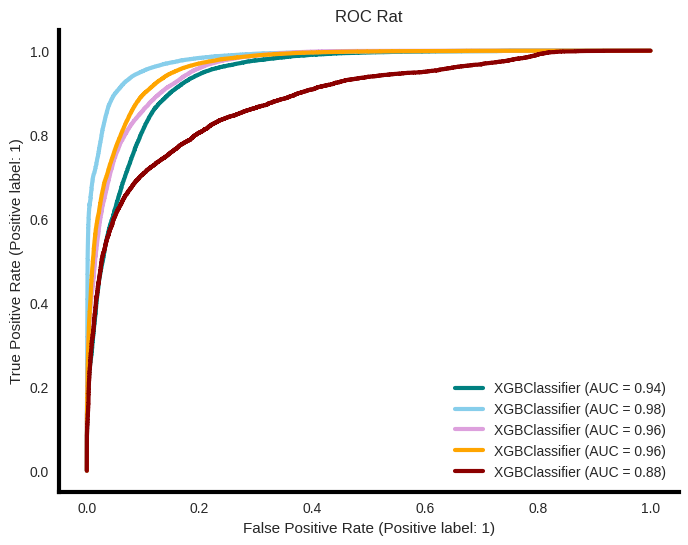

In [26]:
from yellowbrick import classifier
fig, axes = plt.subplots(figsize = (8, 6), ncols = 1)

metrics.RocCurveDisplay.from_estimator(xgb_grid, train_fold_1, y_train_fold_1, ax = axes, color = 'teal', linewidth=3) #label = 'CV Fold 1', color = 'teal', linewidth=3)
metrics.RocCurveDisplay.from_estimator(xgb_grid, train_fold_2, y_train_fold_2, ax = axes, color = 'skyblue', linewidth=3) #, label = 'CV Fold 2', color = 'skyblue', linewidth=3)
metrics.RocCurveDisplay.from_estimator(xgb_grid, train_fold_3, y_train_fold_3, ax = axes, color = 'plum', linewidth=3) #, label = 'CV Fold 3', color = 'plum', linewidth=3)
metrics.RocCurveDisplay.from_estimator(xgb_grid, X_train_new, y_train_res, ax = axes, color = 'orange', linewidth=3)
metrics.RocCurveDisplay.from_estimator(xgb_grid, X_test_new, y_test_res, ax = axes, color = 'darkred', linewidth = 3) #, label = 'Test', color='darkred', linewidth=3)
axes.set(title = 'ROC Rat')
axes.grid(False)

# Remove the top and right spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

# Make bottom (X-axis) and left (Y-axis) spines thicker
axes.spines['bottom'].set_linewidth(3)
axes.spines['left'].set_linewidth(3)
axes.spines['bottom'].set_edgecolor('black')
axes.spines['left'].set_edgecolor('black')

# Remove the background grid
axes.grid(False)
# Save the plot as a PNG file
plt.savefig('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/' + 'roc_curve_train_test.jpg', format='png')

# Save the plot as an SVG file
plt.savefig('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/' + 'roc_curve_train_test.svg', format='svg')
plt.show()


In [ ]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

# Confusion Matrix for CV Fold 1
cm1 = metrics.confusion_matrix(y_train_fold_1, xgb_grid.predict(train_fold_1), normalize = 'true')
disp1 = metrics.ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['DS', 'SE'])
disp1.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('CV Fold 1')

# Confusion Matrix for CV Fold 2
cm2 = metrics.confusion_matrix(y_train_fold_2, xgb_grid.predict(train_fold_2), normalize = 'true')
disp2 = metrics.ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['DS', 'SE'])
disp2.plot(ax=axes[1], cmap='Blues')
axes[1].set_title('CV Fold 2')

# Confusion Matrix for CV Fold 3
cm3 = metrics.confusion_matrix(y_train_fold_3, xgb_grid.predict(train_fold_3), normalize = 'true')
disp3 = metrics.ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=['DS', 'SE'])
disp3.plot(ax=axes[2], cmap='Blues')
axes[2].set_title('CV Fold 3')

# Adjust layout
plt.tight_layout()

# Change directory to save the plots
os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/')

# Save the plots
plt.savefig('confusion_matrix_cv_folds_normalise.jpg')
plt.savefig('confusion_matrix_cv_folds_normalise.svg')

plt.show()


In [ ]:
fig, ax = plt.subplots(figsize = (8,4))

cm_test = metrics.confusion_matrix(y_test_res,  xgb_grid.predict(X_test_new)) #, normalize = 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = ['WT', 'GAP'])
disp.plot(ax = ax, cmap = 'Blues')

os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/')
plt.savefig('confusion_matrix_test.jpg')
plt.savefig('confusion_matrix_test.svg')
plt.show()

In [19]:
import shap 
shap.initjs()
shap_ex = shap.TreeExplainer(xgb_grid)
train_vals = shap_ex(X_train_new)
test_vals = shap_ex(X_test_new)

In [20]:
shap_df = pd.DataFrame(train_vals.values, columns = X_train_new.columns)
shap_df

,Motor_DispEn,Motor_Hurst,Motor_HFD,Motor_Gamma,Motor_Theta,Soma_DispEn,Soma_Hurst,Soma_HFD,Soma_Gamma,Soma_Theta,...,Mot_CC_Left,Som_CC_Right,Som_CC_Left,Vis_CC_Right,Mot_PL_Right,Mot_PL_Left,Som_PL_Right,Som_PL_Left,Vis_PL_Right,Vis_PL_Left
0,0.002518,0.0,0.016829,0.164556,0.000348,0.152165,-0.039040,0.052525,0.204043,0.001668,...,-0.028730,-1.018946,-0.010543,-0.084464,-0.022089,-0.003413,-0.167949,-0.016157,-0.046863,0.025244
1,-0.003346,0.0,0.007532,0.033172,0.000348,-0.176743,-0.162600,0.067470,0.098546,0.002216,...,-0.021144,-1.006067,-0.022961,-0.066321,-0.035101,0.000906,-0.139743,-0.029419,-0.084309,0.019655
2,-0.007756,0.0,0.007668,0.353516,0.003227,-0.175202,-0.166498,0.069977,0.129424,-0.019079,...,0.042847,-0.856669,-0.038991,-0.093894,-0.028243,0.005075,-0.071487,-0.024362,-0.079234,0.018722
3,-0.030195,0.0,0.015873,0.402086,0.002425,-0.176878,-0.229835,0.072992,0.226419,0.002216,...,0.057327,-0.341097,-0.017032,-0.051048,-0.005040,0.001099,-0.008289,-0.017301,-0.067660,0.017488
4,0.002518,0.0,0.007532,0.338422,0.004029,-0.153429,-0.080077,0.032803,0.183888,0.001668,...,-0.031020,-1.006706,-0.017630,0.002094,-0.015231,-0.003051,-0.143087,-0.015494,-0.021852,0.014151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190643,0.004409,0.0,0.024073,0.223986,-0.000342,0.283930,-0.062627,0.056918,0.494268,-0.014529,...,-0.001426,0.349974,0.006678,-0.022605,-0.003259,-0.003016,0.100860,0.011335,-0.018165,0.006023
190644,-0.003346,0.0,-0.008023,-0.079697,0.001011,-0.054188,0.058592,-0.145604,0.108207,0.016198,...,-0.024062,1.308944,-0.033842,-0.019094,-0.003347,0.028009,0.152170,-0.010093,-0.024176,-0.003354
190645,-0.001763,0.0,-0.007100,-0.124005,0.001011,-0.043762,0.047173,-0.147469,-0.333449,0.016198,...,-0.025642,1.281968,-0.019351,0.129833,-0.002444,0.027795,0.128016,-0.006587,0.003671,-0.009617
190646,-0.010612,0.0,-0.013998,-0.071604,0.000498,-0.105420,0.039057,-0.275726,-0.231775,0.002670,...,-0.024410,-0.445491,-0.008445,-0.026743,-0.004175,0.016724,-0.072886,-0.023152,-0.065119,-0.004223


In [21]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_data = X_train.iloc[:,1:5]
X_test_data = X_test.iloc[:,1:5]
clf.fit(X_train_data, y_train)
pred = clf.predict(X_test_data)
sub = pd.DataFrame(data=X_test)
sub['pred'] = pred
sub.head() #Shows the first few rows

NameError: name 'X' is not defined

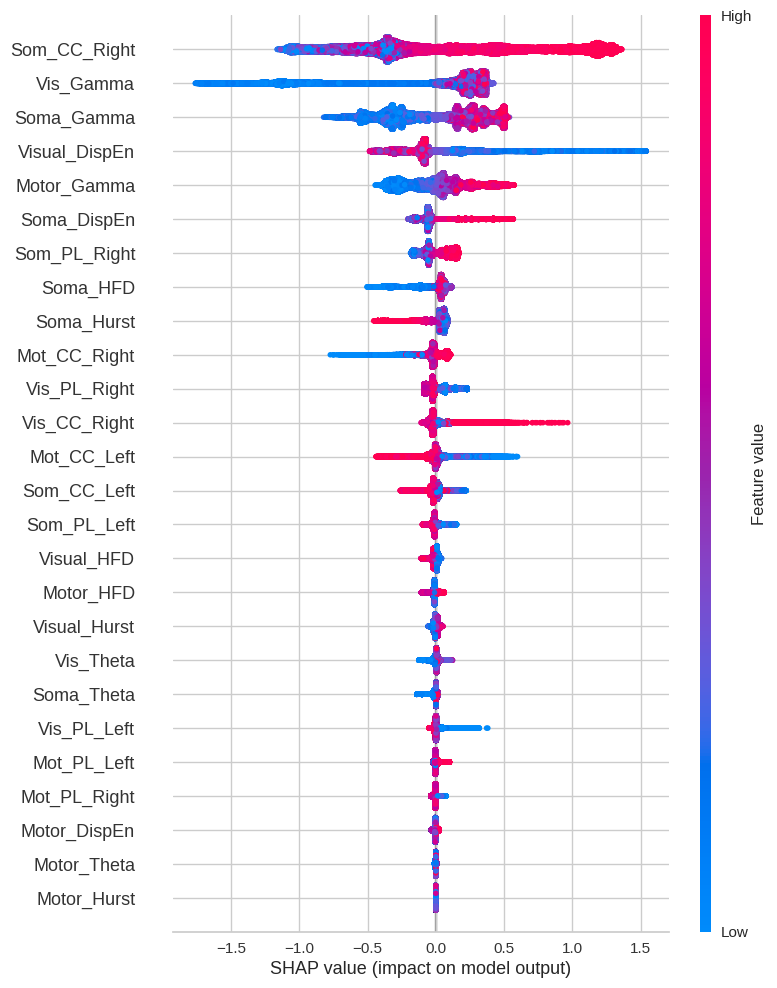

In [41]:
fig = plt.figure(figsize = (8, 4))
shap.plots.beeswarm(train_vals, max_display = len(X_train_new.columns))


# Save the figure as a PNG file
#plt.savefig('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/shap_beeswarm_plot_train.png', format='png')

# Save the figure as an SVG file
#plt.savefig('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/shap_beeswarm_plot_train.svg', format='svg')

plt.show()  # Display the plot

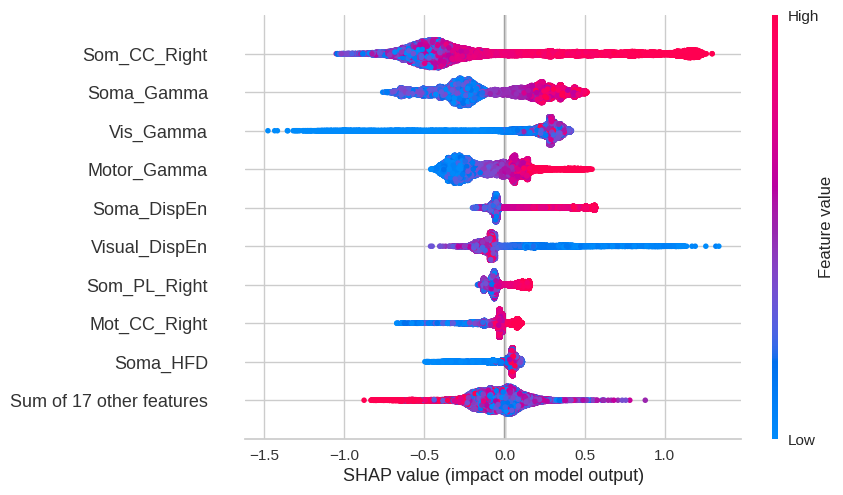

In [42]:
fig = plt.figure(figsize = (8, 4))
shap.plots.beeswarm(test_vals, max_display = len(X_test_new.columns[0:10]))

# Attempt to access the current axes and remove the grid

# Save the figure as a PNG file
#plt.savefig('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/shap_beeswarm_plot_test_shortened.png', format='png')

# Save the figure as an SVG file
#plt.savefig('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/shap_beeswarm_plot_test_shortened.svg', format='svg')

#plt.show()  # Display the plot

## Understanding features with dependence plots 

<Figure size 800x400 with 0 Axes>

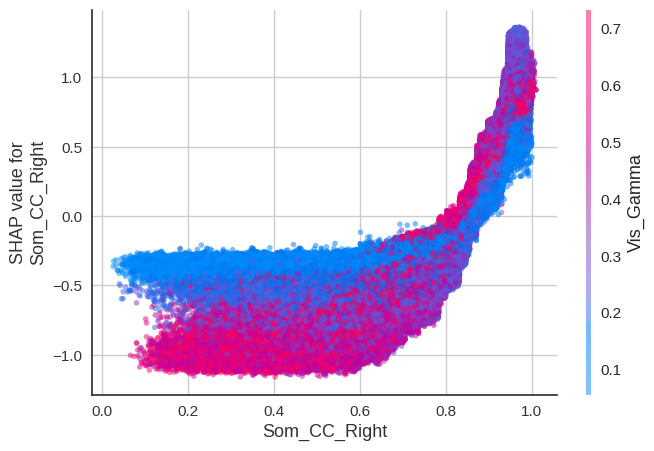

In [33]:
fig = plt.figure(figsize = (8, 4))
shap.plots.scatter(train_vals[:, 'Som_CC_Right'], color = train_vals,x_jitter = 1,alpha = 0.5, hist = False)
#os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/Dependence_Plots/')
#plt.savefig('som_cc_right.png', format='png')
#plt.savefig('som_cc_right.svg', format='svg')

<Figure size 800x400 with 0 Axes>

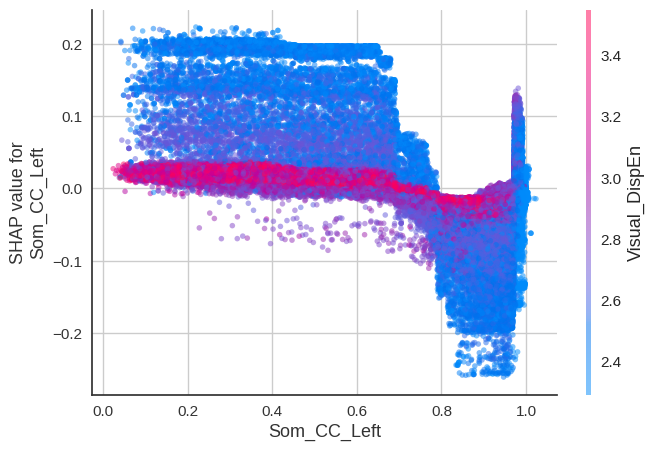

In [35]:
fig = plt.figure(figsize = (8, 4))
shap.plots.scatter(train_vals[:, 'Som_CC_Left'], color = train_vals,x_jitter = 1,alpha = 0.5, hist = False)
#os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/Dependence_Plots/')
#plt.savefig('som_cc_left.png', format='png')
#plt.savefig('som_cc_left.svg', format='svg')

<Figure size 800x400 with 0 Axes>

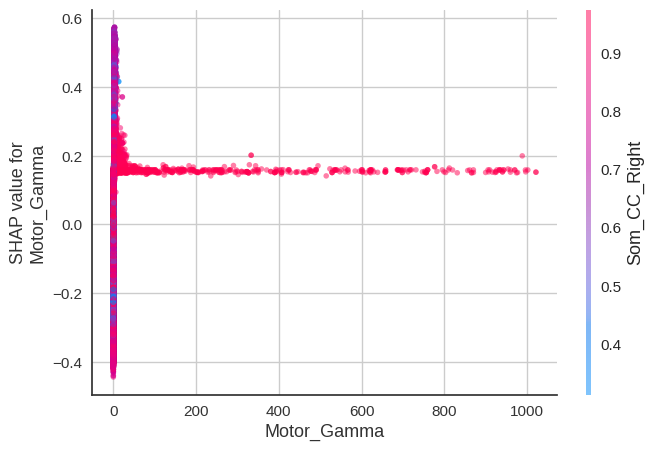

In [36]:
fig = plt.figure(figsize = (8, 4))
shap.plots.scatter(train_vals[:, 'Motor_Gamma'], color = train_vals,x_jitter = 1,alpha = 0.5, hist = False)
#os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/Dependence_Plots/')
#plt.savefig('motor_gamma.png', format='png')
#plt.savefig('motor_gamma.svg', format='svg')

<Figure size 800x400 with 0 Axes>

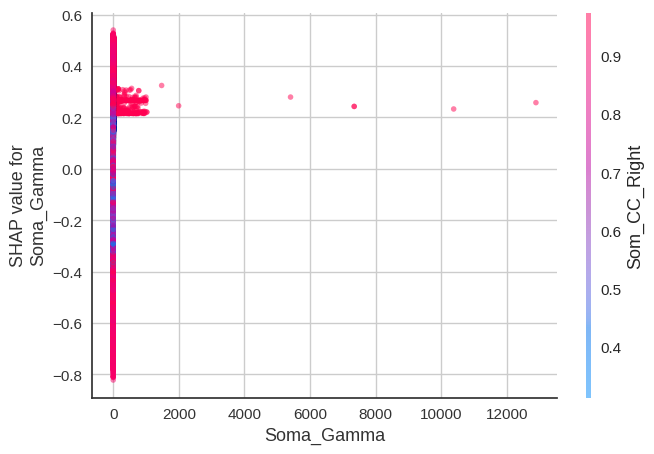

In [37]:
fig = plt.figure(figsize = (8, 4))
shap.plots.scatter(train_vals[:, 'Soma_Gamma'], color = train_vals,x_jitter = 1,alpha = 0.5, hist = False)
#os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/Dependence_Plots/')
#plt.savefig('soma_gamma.png', format='png')
#plt.savefig('soma_gamma.svg', format='svg')

<Figure size 800x400 with 0 Axes>

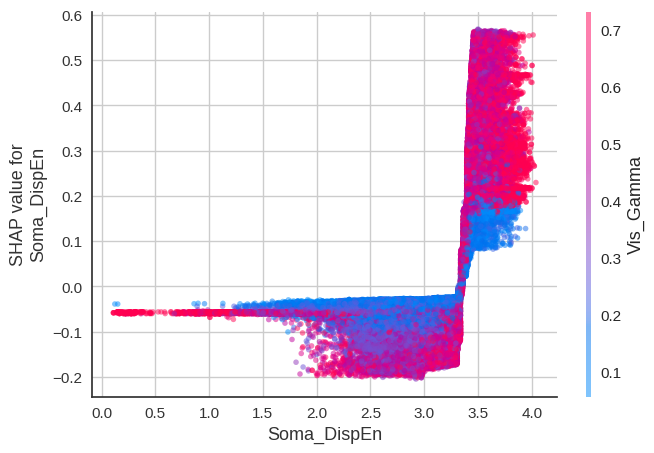

In [38]:
fig = plt.figure(figsize = (8, 4))
shap.plots.scatter(train_vals[:, 'Soma_DispEn'], color = train_vals,x_jitter = 1,alpha = 0.5,hist = False)
#os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/Dependence_Plots/')
#plt.savefig('soma_dispen.png', format='png')
#plt.savefig('soma_dispen.svg', format='svg')

<Figure size 800x400 with 0 Axes>

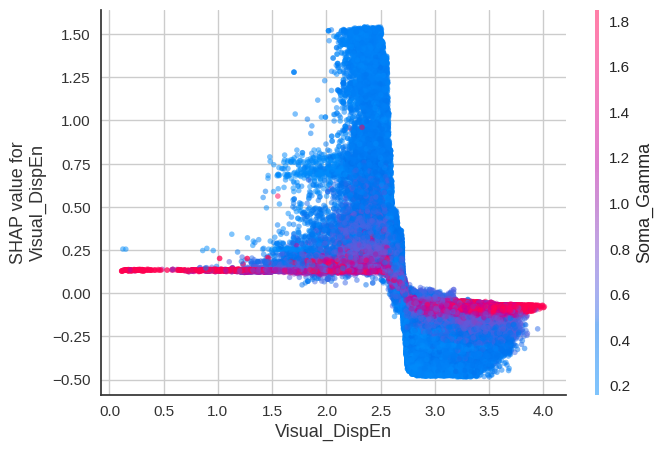

In [39]:
fig = plt.figure(figsize = (8, 4))
shap.plots.scatter(train_vals[:, 'Visual_DispEn'], color = train_vals,x_jitter = 1,alpha = 0.5, hist = False)
#os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/Dependence_Plots/')
#plt.savefig('visual_dispen.png', format='png')
#plt.savefig('visual_dispen.svg', format='svg')

<Figure size 800x400 with 0 Axes>

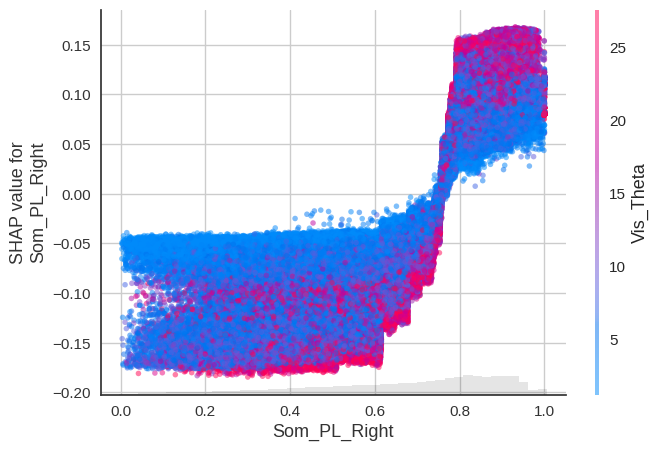

In [40]:
fig = plt.figure(figsize = (8, 4))
shap.plots.scatter(train_vals[:, 'Som_PL_Right'], color = train_vals,x_jitter = 1, alpha = 0.5)
#os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/Dependence_Plots/')
#plt.savefig('som_pl_right.png', format='png')
#plt.savefig('som_pl_right.svg', format='svg')

## Heatmap Plots

Create a heatmap of the correlation of SHAP values for each prediction

<Axes: >

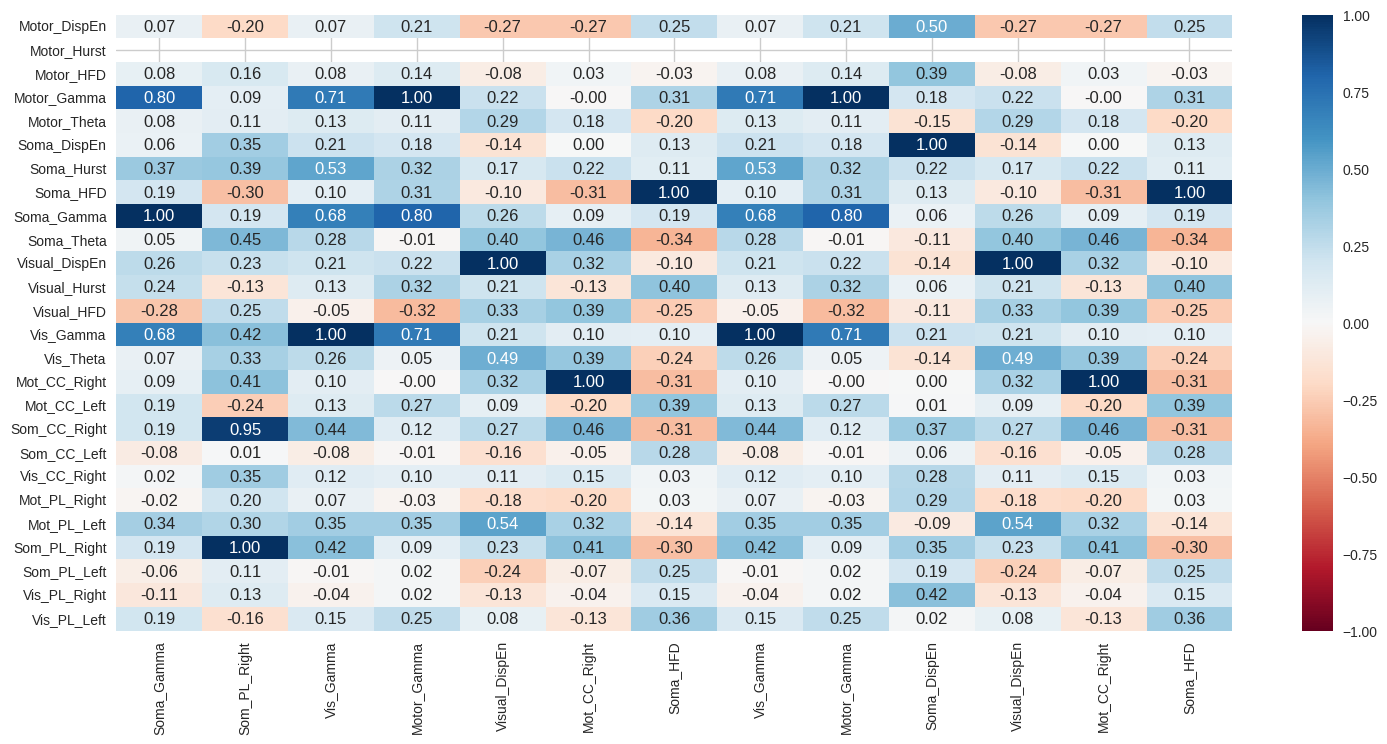

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (18, 8))
sns.heatmap(shap_df.assign()
.corr(method = 'spearman').loc[:, ['Soma_Gamma', 'Som_PL_Right','Vis_Gamma',
                                   'Motor_Gamma','Visual_DispEn', 'Mot_CC_Right',
                                   'Soma_HFD', 'Vis_Gamma','Motor_Gamma', 'Soma_DispEn',
                                    'Visual_DispEn',  'Mot_CC_Right',  'Soma_HFD']], 
                                cmap = 'RdBu', annot = True, fmt = '.2f', vmin = -1, vmax = 1, ax = ax)


#os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/Dependence_Plots/')
#plt.savefig('shap_heatmap_spearman_corr.png', format='png')
#plt.savefig('shap_heatmap_spearman_corr.svg', format='svg')

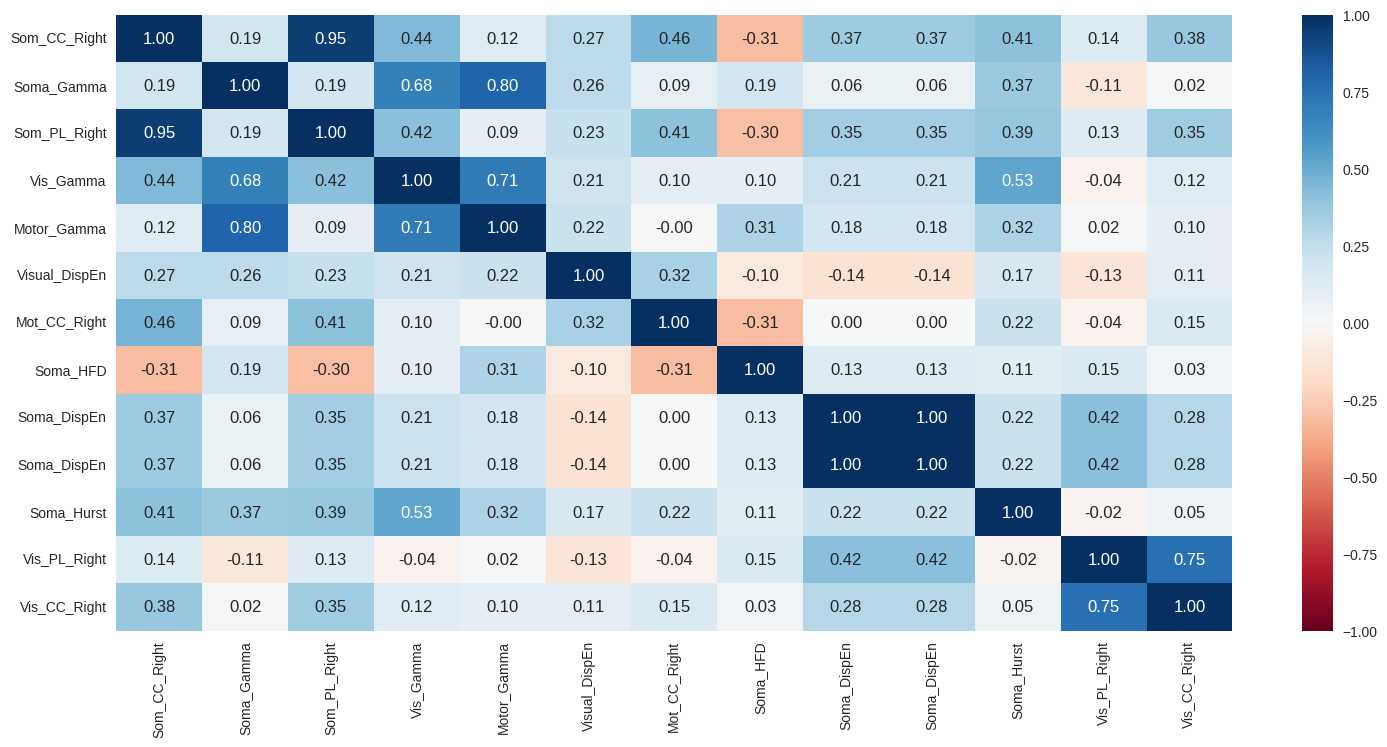

In [26]:
# Define the list of features
features = ['Som_CC_Right', 'Soma_Gamma', 'Som_PL_Right',
            'Vis_Gamma', 'Motor_Gamma', 
            'Visual_DispEn', 'Mot_CC_Right', 'Soma_HFD', 'Soma_DispEn',
           'Soma_DispEn', 'Soma_Hurst', 'Vis_PL_Right', 'Vis_CC_Right']

# Assuming 'shap_df' is your DataFrame and it contains these features
# Compute the Spearman correlation matrix using these features
corr_matrix = shap_df[features].corr(method='spearman')

# Create the heatmap
fig, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(corr_matrix, cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax)

os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Rat/Evaluation_Plots/XGBoost/Dependence_Plots/')
plt.savefig('shap_heatmap_spearman_corr.png', format='png')
plt.savefig('shap_heatmap_spearman_corr.svg', format='svg')


## Look at predicitons and see if the percentage of correct predictions 

In [ ]:
pred_train = xgb_grid.predict(X_train_new)

In [ ]:
copy_X_train_res = X_train_res.copy()
copy_X_train_res["pred"] = pred_train

In [ ]:
count_matches = copy_X_train_res['Genotype'].eq(copy_X_train_res['pred']).groupby(copy_X_train_res['Animal_ID']).sum()

print(count_matches / copy_X_train_res.groupby("Animal_ID").count()["Genotype"])

In [ ]:
copy_X_train_res.groupby("Animal_ID").agg(test)

In [ ]:
copy_X_test_res= X_test_res.copy()
copy_X_test_res["pred"] = pred_test

count_matches = copy_X_test_res['Genotype'].eq(copy_X_test_res['pred']).groupby(copy_X_test_res['Animal_ID']).sum()

print(count_matches / copy_X_test_res.groupby("Animal_ID").count()["Genotype"])

In [ ]:
print('train wildtype')
print(len(X_train.loc[X_train['Genotype'] == 0]))
print('train gap')
print(len(X_train.loc[X_train['Genotype'] == 1]))
print('test wildtype')
print(len(X_test.loc[X_test['Genotype'] == 0]))
print('test gap')
print(len(X_test.loc[X_test['Genotype'] == 1]))

In [ ]:
print('train wildtype')
print(len(X_train_res.loc[X_train_res['Genotype'] == 0]))
print('train gap')
print(len(X_train_res.loc[X_train_res['Genotype'] == 1]))
print('test wildtype')
print(len(X_test_res.loc[X_test_res['Genotype'] == 0]))
print('test gap')
print(len(X_test_res.loc[X_test_res['Genotype'] == 1]))